<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/sushweta/notebooks/Car_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPSTONE PROJECT

Our training script begins with a selection of imports. These include:

config: The configuration file consisting of paths and hyperparameters

VGG16: The CNN architecture to serve as the base network for our fine tuning approach

tf.keras: Imports from TensorFlow/Keras consisting of layer types, optimizers, and image loading/preprocessing routines

train_test_split: Scikit-learn’s convenience utility for slicing our network into training and testing subsets

matplotlib: Python’s de facto plotting package

numpy: Python’s standard numerical processing library

cv2: OpenCV

In [1]:
import os
import cv2
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical


In [2]:
#import Car_model_config

In [3]:
BASE_PATH = "/content/drive/My Drive/Capstone Data"
TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

In [4]:
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
# A text file of image filenames selected for our testing set
TEST_FILENAMES = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "test_images.txt"])
print(TEST_FILENAMES)

/content/drive/My Drive/Capstone Data/output/test_images.txt


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load the contents of the CSV annotations file

# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
trainfilenames = []
testfilenames = []
labels = []
bboxes = []
trainimagePaths = []

testdata = []
testtargets = []
testbboxes = []


In [7]:
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT)
car_map=car_map.set_index('Cars')


In [8]:
car_map.head()

,Class Numbers
Cars,
AM General Hummer SUV 2000,0
Acura RL Sedan 2012,1
Acura TL Sedan 2012,2
Acura TL Type-S 2008,3
Acura TSX Sedan 2012,4


In [9]:
car_map.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, AM General Hummer SUV 2000 to smart fortwo Convertible 2012
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Class Numbers  196 non-null    int64
dtypes: int64(1)
memory usage: 3.1+ KB


In [10]:
car_map_dict=car_map.to_dict('index')
list(car_map_dict.items())[:5]

[('AM General Hummer SUV 2000', {'Class Numbers': 0}),
 ('Acura RL Sedan 2012', {'Class Numbers': 1}),
 ('Acura TL Sedan 2012', {'Class Numbers': 2}),
 ('Acura TL Type-S 2008', {'Class Numbers': 3}),
 ('Acura TSX Sedan 2012', {'Class Numbers': 4})]

In [11]:
#fetch a key based on value passed - we need this to build our image paths
print(list(car_map_dict.keys())[173])

Ram C-V Cargo Van Minivan 2012


In [12]:
df_init= pd.read_csv(TRAIN_ANNOTS_PATH)

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Image Name                8144 non-null   object
 1   Bounding Box coordinates  8144 non-null   int64 
 2   Unnamed: 2                8144 non-null   int64 
 3   Unnamed: 3                8144 non-null   int64 
 4   Unnamed: 4                8144 non-null   int64 
 5   Image class               8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [13]:
df_inittest= pd.read_csv(TEST_ANNOTS_PATH)

df_inittest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Image Name                8041 non-null   object
 1   Bounding Box coordinates  8041 non-null   int64 
 2   Unnamed: 2                8041 non-null   int64 
 3   Unnamed: 3                8041 non-null   int64 
 4   Unnamed: 4                8041 non-null   int64 
 5   Image class               8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [14]:
df_tidy = df_init.rename(columns = {'Bounding Box coordinates': 'StartX', 'Unnamed: 2' : 'StartY', 'Unnamed: 3':'EndX', 'Unnamed: 4':'EndY'}, inplace = False)
df_tidytest = df_inittest.rename(columns = {'Bounding Box coordinates': 'StartX', 'Unnamed: 2' : 'StartY', 'Unnamed: 3':'EndX', 'Unnamed: 4':'EndY'}, inplace = False)

In [15]:
#Update train dataframe
Classname = []
X1 = []
Y1 = []
X2 = []
Y2 = []
TrainFiles = []

for dfrow in tqdm(df_tidy.iterrows()):
      
  lbl = int(dfrow[1]['Image class'])-1
  keyName = list(car_map_dict.keys())[lbl]
  fname = dfrow[1]['Image Name']
  imagePathtrain = os.path.sep.join([TRAIN_IMAGES_PATH, keyName, fname])
      #print(imagePathtrain)

  startX = dfrow[1]['StartX']
  startY = dfrow[1]['StartY']
  endX = dfrow[1]['EndX']
  endY = dfrow[1]['EndY']
  image = cv2.imread(imagePathtrain)
  (h, w) = image.shape[:2]
  #print(h,w)

  # scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  #print(fname, lbl, keyName, startX, startY, endX, endY)
  #print(dfrow[1])

  Classname.append(keyName)
  X1.append(startX)
  Y1.append(startY)
  X2.append(endX)
  Y2.append(endY)
  bboxes.append((startX, startY, endX, endY))
  TrainFiles.append(imagePathtrain)

      
df_tidy['Classname'] = Classname
df_tidy['X1'] = X1
df_tidy['Y1'] = Y1
df_tidy['X2'] = X2
df_tidy['Y2'] = Y2

df_tidy['Filepath'] = TrainFiles

8144it [25:58,  5.23it/s]


In [16]:

print(df_tidy['Filepath'][100])
print(df_tidy['Filepath'][200])
print(df_tidy['Filepath'][300])
print(df_tidy['Filepath'][400])

/content/drive/My Drive/Capstone Data/Car Images/Train Images/Volvo C30 Hatchback 2012/00101.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Audi RS 4 Convertible 2008/00201.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/GMC Acadia SUV 2012/00301.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Dodge Sprinter Cargo Van 2009/00401.jpg


In [17]:
df_tidy.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0.065000,0.290000,0.948333,0.937500,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0.040000,0.171852,0.964444,0.869630,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0.132812,0.227083,0.939063,0.793750,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0.295714,0.283550,0.706667,0.790765,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0.097222,0.333333,0.923611,0.916667,/content/drive/My Drive/Capstone Data/Car Imag...


In [18]:
_Classname = []
_X1 = []
_Y1 = []
_X2 = []
_Y2 = []
TestFiles = []

for dfrow in tqdm(df_tidytest.iterrows()):
      
      lbl = int(dfrow[1]['Image class'])-1
      keyName = list(car_map_dict.keys())[lbl]
      fname = dfrow[1]['Image Name']
      imagePathtest = os.path.sep.join([TEST_IMAGES_PATH, keyName, fname])
      #print(imagePathtrain)

      startX = dfrow[1]['StartX']
      startY = dfrow[1]['StartY']
      endX = dfrow[1]['EndX']
      endY = dfrow[1]['EndY']
      image = cv2.imread(imagePathtest)
      (h, w) = image.shape[:2]
      #print(h,w)

      # scale the bounding box coordinates relative to the spatial
		  # dimensions of the input image
      startX = float(startX) / w
      startY = float(startY) / h
      endX = float(endX) / w
      endY = float(endY) / h
      #print(fname, lbl, keyName, startX, startY, endX, endY)
      #print(dfrow[1])

      _Classname.append(keyName)
      _X1.append(startX)
      _Y1.append(startY)
      _X2.append(endX)
      _Y2.append(endY)
      testbboxes.append((startX, startY, endX, endY))
      TestFiles.append(imagePathtest)

      
df_tidytest['Classname'] = _Classname
df_tidytest['X1'] = _X1
df_tidytest['Y1'] = _Y1
df_tidytest['X2'] = _X2
df_tidytest['Y2'] = _Y2

df_tidytest['Filepath'] = TestFiles

8041it [32:53,  4.08it/s]


In [19]:
print(df_tidytest['Filepath'][150])
print(df_tidytest['Filepath'][250])
print(df_tidytest['Filepath'][350])
print(df_tidytest['Filepath'][450])

/content/drive/My Drive/Capstone Data/Car Images/Test Images/Chrysler PT Cruiser Convertible 2008/00151.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Acura ZDX Hatchback 2012/00251.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Chevrolet TrailBlazer SS 2009/00351.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Bentley Continental GT Coupe 2007/00451.jpg


In [20]:
df_tidytest.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,0.108696,0.285714,0.891304,0.807692,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,0.156250,0.052778,0.900000,0.563889,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,0.049805,0.141700,0.945312,0.889339,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,0.104688,0.175000,0.907813,0.847917,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,0.233333,0.404826,0.988333,0.908847,/content/drive/My Drive/Capstone Data/Car Imag...


In [21]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w+")
f.write("\n".join(TestFiles))
f.close()

[INFO] saving testing filenames...


In [22]:
for imagePath in tqdm(TrainFiles):

    # load the image and preprocess it
		image = load_img(imagePath, target_size=(224, 224))
		image = img_to_array(image)
		# update our list of data, class labels, bounding boxes, and
		# image paths
		data.append(image)

100%|██████████| 8144/8144 [01:15<00:00, 108.20it/s]


In [39]:
testdata = []
for imagePath in tqdm(TestFiles):

    # load the image and preprocess it
		image = load_img(imagePath, target_size=(224, 224))
		image = img_to_array(image)
		# update our list of data, class labels, bounding boxes, and
		# image paths
		testdata.append(image)

100%|██████████| 8041/8041 [03:07<00:00, 42.94it/s]


In [40]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
trainlabels = lb.fit_transform(Classname)
testlabels = lb.fit_transform(_Classname)

In [32]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
trainImages = np.array(data, dtype="float32") / 255.0
trainLabels = np.array(trainlabels)
trainBBoxes = np.array(bboxes, dtype="float32")
trainPaths = np.array(TrainFiles)

In [41]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
testImages = np.array(testdata, dtype="float32") / 255.0
testLabels = np.array(testlabels)
testBBoxes = np.array(testbboxes, dtype="float32")
testPaths = np.array(TestFiles)

In [42]:
INIT_LR = 1e-4


# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
#model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")

H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/20
255/255 [==============================] - 505s 2s/step - loss: 5.3264 - bounding_box_loss: 0.0041 - class_label_loss: 5.3223 - bounding_box_accuracy: 0.7889 - class_label_accuracy: 0.0050 - val_loss: 5.2779 - val_bounding_box_loss: 0.0017 - val_class_label_loss: 5.2762 - val_bounding_box_accuracy: 0.8424 - val_class_label_accuracy: 0.0046
Epoch 2/20
255/255 [==============================] - 500s 2s/step - loss: 5.2785 - bounding_box_loss: 0.0012 - class_label_loss: 5.2773 - bounding_box_accuracy: 0.8689 - class_label_accuracy: 0.0059 - val_loss: 5.2730 - val_bounding_box_loss: 0.0014 - val_class_label_loss: 5.2716 - val_bounding_box_accuracy: 0.8620 - val_class_label_accuracy: 0.0078
Epoch 3/20
255/255 [==============================] - 503s 2s/step - loss: 5.2740 - bounding_box_loss: 8.6182e-04 - class_label_loss: 5.2731 - bounding_box_accuracy: 0.8824 - class_label_accuracy: 0.0068 - val_loss: 5.2652 - val_bounding_box_loss: 0.00

In [45]:
# The path to our TensorFlow-serialized output model
MODEL_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "lb.pickle"])

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving object detector model...
[INFO] saving label binarizer...


<Figure size 432x288 with 0 Axes>

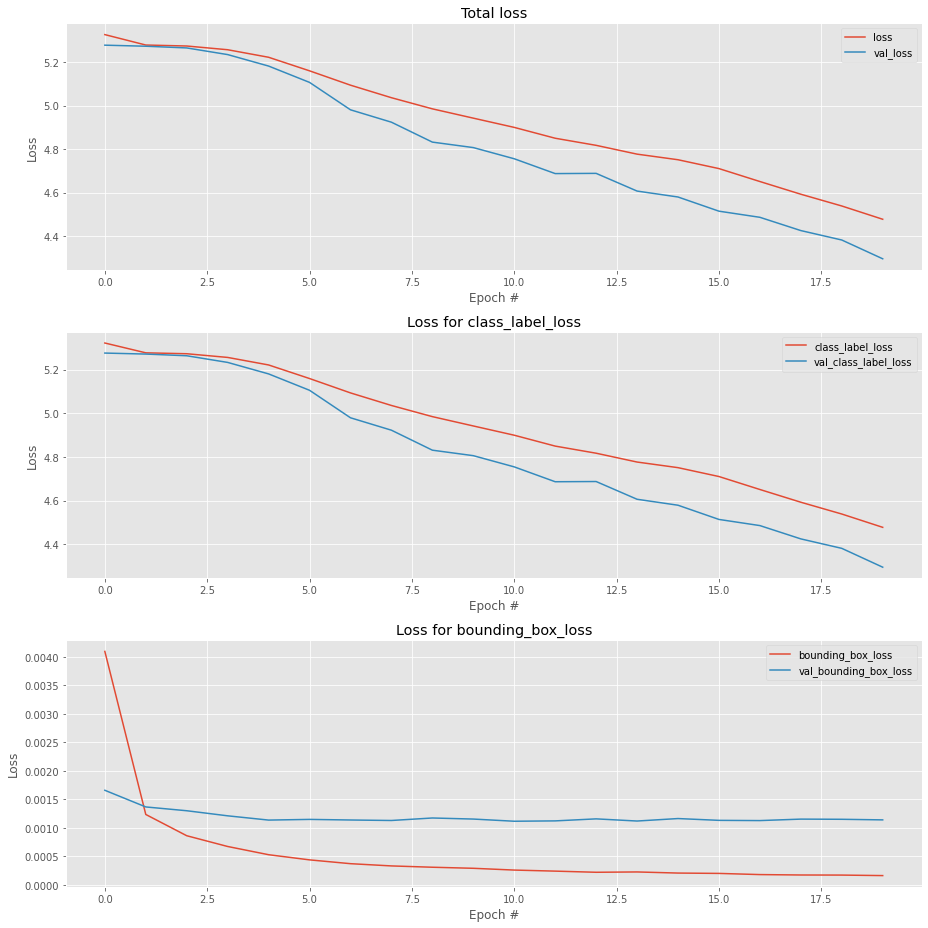

In [55]:
# The output training history plot consisting of accuracy and loss curves
PLOT_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "plots"])

# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOT_PATH, "losses.png"])
plt.savefig(plotPath)



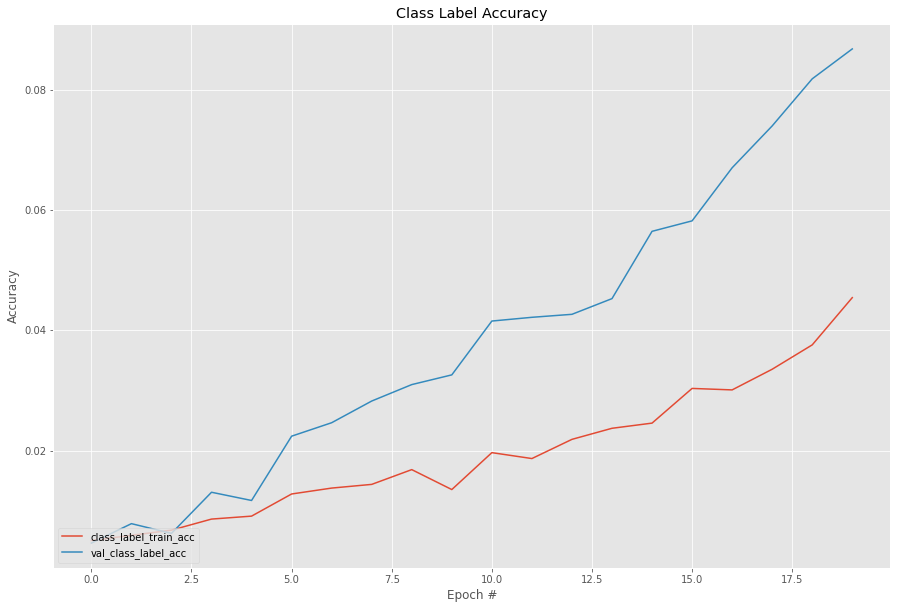

In [58]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOT_PATH, "accs.png"])
plt.savefig(plotPath)